In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pprint import pprint

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation

C:\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [111]:
import xgboost as xgb

In [2]:
%matplotlib inline

# I. Importing data

In [4]:
train = pd.read_csv('shelter.csv')
test = pd.read_csv('test.csv')

df = train.drop(['AnimalID', 'DateTime','OutcomeSubtype', 'OutcomeType'], axis=1)
df = df.append(test.drop(['ID', 'DateTime'], axis=1), ignore_index=True)
print (train.shape, test.shape, df.shape)
df.tail(3)

(26729, 10) (11456, 8) (38185, 6)


,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
38182,NaN,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
38183,Rambo,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
38184,Gusto,Dog,Intact Male,4 years,Labrador Retriever,Cream


#### 1. Shape of Dataset

In [5]:
df.shape # rows & columns

(38185, 6)

# II. Preprocessing

### 1. NaN value

#### 1) count

In [6]:
df.count()

Name              27269
AnimalType        38185
SexuponOutcome    38184
AgeuponOutcome    38161
Breed             38185
Color             38185
dtype: int64

#### 2) Number of NaNs for each column

In [7]:
print ( df.isnull().sum())

Name              10916
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       24
Breed                 0
Color                 0
dtype: int64


### 2. Handling categorical variables

##### Copy

In [10]:
copy = df.copy()
copy.tail(3)

,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
38182,NaN,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
38183,Rambo,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
38184,Gusto,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [11]:
group_copy = train.copy()

#### 1) AgeuponOutcome

In [12]:
def age_to_day(x):
    try:
        if x != '0 years':
            x_splited = x.split(' ')
            if x_splited[1] in 'years':
                return int(x_splited[0]) * 365
            elif x_splited[1] in 'months':
                return int(x_splited[0]) * 30
            elif x_splited[1] in 'weeks':
                return int(x_splited[0]) * 7
            elif x_splited[1] in 'days':
                return int(x_splited[0])
        else:
            return 0
    except:
        pass

def AgeuponOutcome_(feature):
    copy.insert(0, 'Age', copy[feature].apply(age_to_day))
    
    years_0_mean = int(copy['Age'][copy['Age']<=365].mean())
    copy['Age'][copy['Age']==0] = copy['Age'][copy['Age']==0].apply(lambda x: years_0_mean)
    
    total_mean = int(copy['Age'].mean())
    copy['Age'][copy['Age'].isnull()] = copy['Age'][copy['Age'].isnull()].apply(lambda x: total_mean)
    
    copy['Age'] = copy['Age'].apply(int)
    del copy[feature] 
    
    return copy

In [13]:
copy = AgeuponOutcome_('AgeuponOutcome')

C:\python35\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\python35\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
copy.head(5)

,Age,Name,AnimalType,SexuponOutcome,Breed,Color
0,365,Hambone,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White
1,365,Emily,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby
2,730,Pearce,Dog,Neutered Male,Pit Bull Mix,Blue/White
3,21,NaN,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream
4,730,NaN,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan


#### 2) Name

In [15]:
def Name_(feature):
    copy[feature] = copy[feature].apply(lambda x: 0 if pd.isnull(x) else 1)
    return copy
# pd.isnull(copy['Name'][0]) => False

def Name_group(feature):
    group_copy[feature] = group_copy[feature].apply(lambda x: 0 if pd.isnull(x) else 1)
    return copy
# pd.isnull(copy['Name'][0]) => False

##### Name의 경우
- Name이 없는 경우와 있는 경우 Adoption과 Return to Owner의 차이가 크다는 것을 알 수 있었다.

In [16]:
Name = Name_group('Name')
shelter_name = group_copy.groupby(['OutcomeType', 'Name'])
shelter_name = pd.DataFrame(shelter_name.size())
shelter_name

0
OutcomeType     Name      
Adoption        0     1678
                1     9091
Died            0      120
                1       77
Euthanasia      0      815
                1      740
Return_to_owner 0      153
                1     4633
Transfer        0     4925
                1     4497

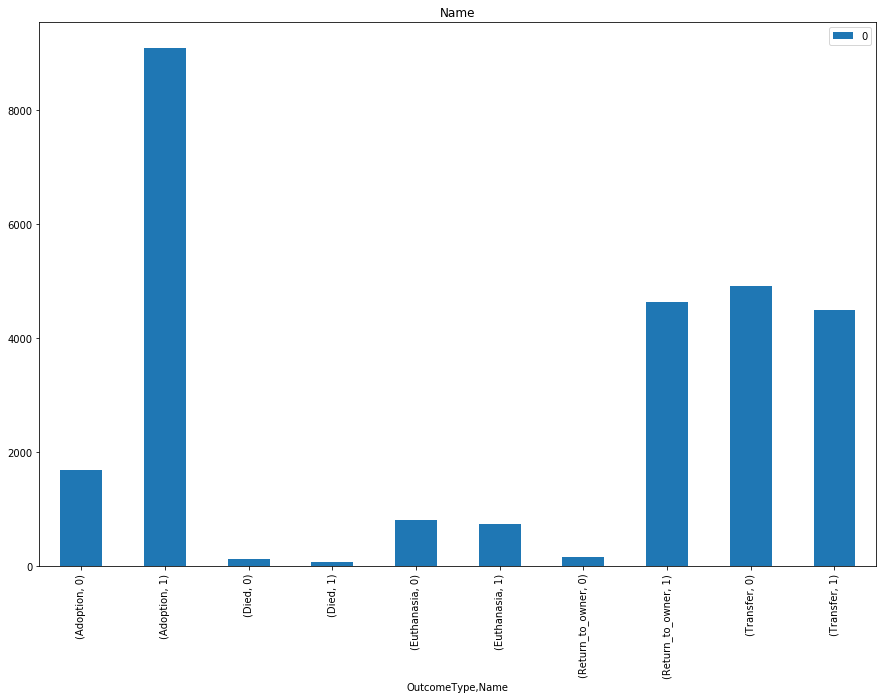

In [17]:
Name_graph = shelter_name.plot(kind='bar', title ="Name", figsize=(15, 10), legend=True, fontsize=10)
plt.show()

In [18]:
copy = Name_('Name')

In [19]:
copy.head(5)

,Age,Name,AnimalType,SexuponOutcome,Breed,Color
0,365,1,Dog,Neutered Male,Shetland Sheepdog Mix,Brown/White
1,365,1,Cat,Spayed Female,Domestic Shorthair Mix,Cream Tabby
2,730,1,Dog,Neutered Male,Pit Bull Mix,Blue/White
3,21,0,Cat,Intact Male,Domestic Shorthair Mix,Blue Cream
4,730,0,Dog,Neutered Male,Lhasa Apso/Miniature Poodle,Tan


#### 3) AnimalType & SexuponOutcome (dummy coding)

In [20]:
def is_Sterilized(x):
    if pd.isnull(x): 
        return 'Unknown'
    elif x.split(' ')[0] == 'Neutered' or x.split(' ')[0] == 'Spayed':
        return 'Sterilized'
    elif x.split(' ')[0] == 'Intact':
        return 'Intact'
    elif x.split(' ')[0] == 'Unknown':
        return 'Unknown'
def is_Sex(x):
    if pd.isnull(x): 
        return 'Unknown'
    elif x == 'Unknown':
        return 'Unknown'
    else:
        return x.split(' ')[1]
def SexuponOutcome_(feature):
    copy['Sterilized'] = copy[feature].apply(is_Sterilized)
    copy['Sex'] = copy[feature].apply(is_Sex)
    del copy[feature]
    return copy
def SexuponOutcome_group(feature):
    group_copy['Sterilized'] = group_copy[feature].apply(is_Sterilized)
    group_copy['Sex'] = group_copy[feature].apply(is_Sex)
    del group_copy[feature]
    return group_copy

###### AnimalType의 경우
- Dog가 Cat에 비해 Adoption 된 경우가 많다.
- Dog에 비해 Cat이 Died 한 경우가 많다.
- Dog에 비해 Cat이 Return to Owner인 경우가 많다.

In [21]:
AnimalType = group_copy.groupby(['OutcomeType', 'AnimalType'])
AnimalType = pd.DataFrame(AnimalType.size())
AnimalType

0
OutcomeType     AnimalType      
Adoption        Cat         4272
                Dog         6497
Died            Cat          147
                Dog           50
Euthanasia      Cat          710
                Dog          845
Return_to_owner Cat          500
                Dog         4286
Transfer        Cat         5505
                Dog         3917

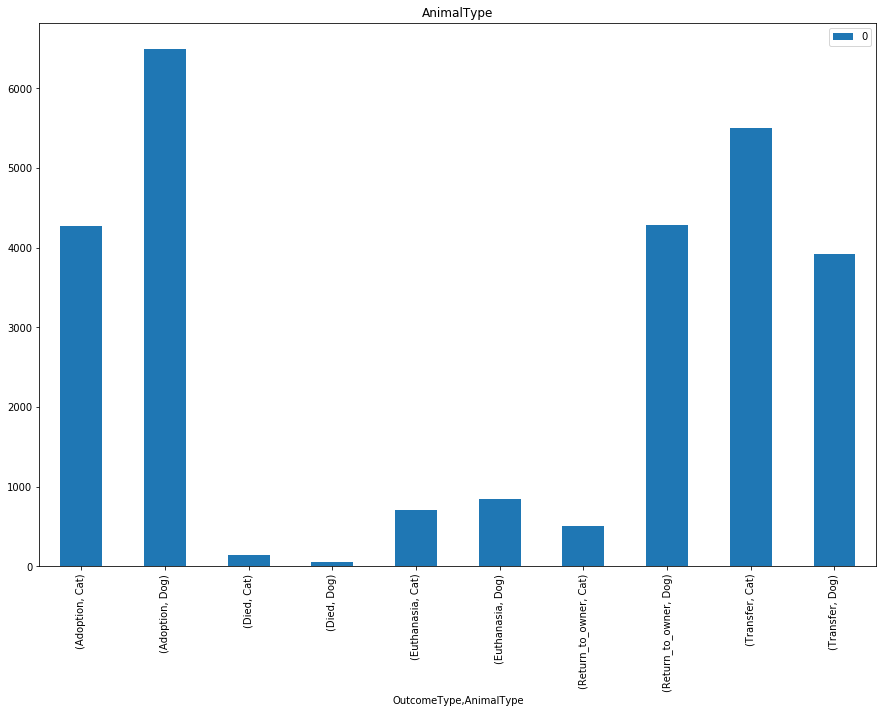

In [22]:
AnimalType_graph = AnimalType.plot(kind='bar', title ="AnimalType", figsize=(15, 10), legend=True, fontsize=10)
plt.show()

##### SexuponOutcome의 중성화 여부의 경우
- 중성화 한 경우가 입양과 주인에게 돌아갈 가능성이 더 크다.

In [23]:
group_copy = SexuponOutcome_group('SexuponOutcome')
Sterilized = group_copy.groupby(['OutcomeType', 'Sterilized'])
Sterilized = pd.DataFrame(Sterilized.size())
Sterilized

0
OutcomeType     Sterilized       
Adoption        Intact        361
                Sterilized  10408
Died            Intact        135
                Sterilized     37
                Unknown        25
Euthanasia      Intact        878
                Sterilized    576
                Unknown       101
Return_to_owner Intact        778
                Sterilized   3995
                Unknown        13
Transfer        Intact       4884
                Sterilized   3583
                Unknown       955

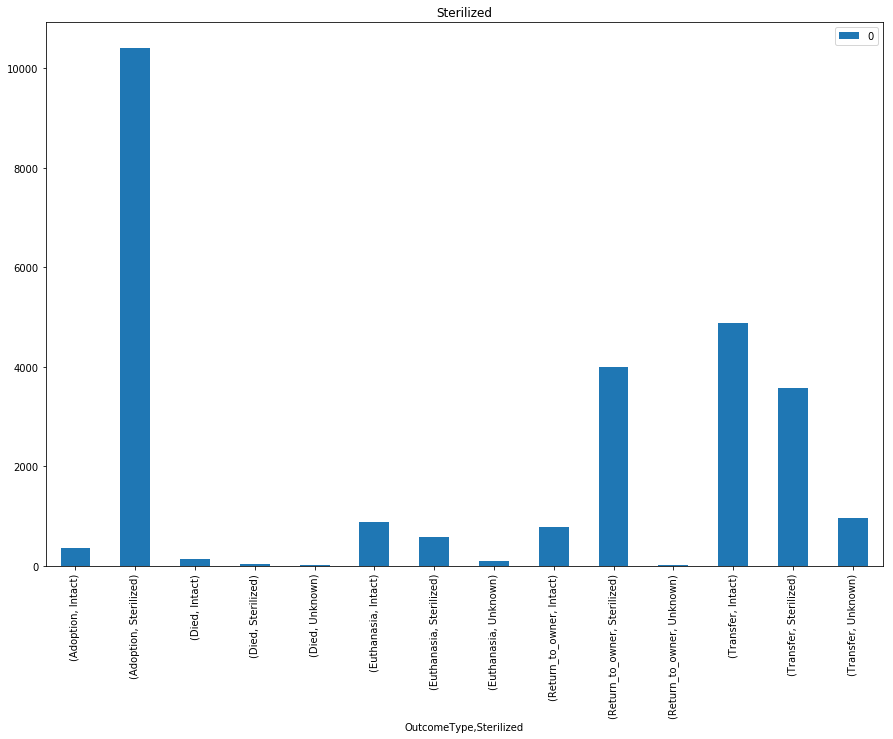

In [24]:
Sterilized_graph = Sterilized.plot(kind='bar', title ="Sterilized", figsize=(15, 10), legend=True, fontsize=10)
plt.show()

##### SexuponOutcome의 성별 여부의 경우
- 각 OutcomeType 별로 남여의 차이가 크지 않다.

In [25]:
Sex = group_copy.groupby(['OutcomeType', 'Sex'])

Sex = pd.DataFrame(Sex.size())
Sex

0
OutcomeType     Sex          
Adoption        Female   5389
                Male     5380
Died            Female     74
                Male       98
                Unknown    25
Euthanasia      Female    633
                Male      821
                Unknown   101
Return_to_owner Female   2049
                Male     2724
                Unknown    13
Transfer        Female   4186
                Male     4281
                Unknown   955

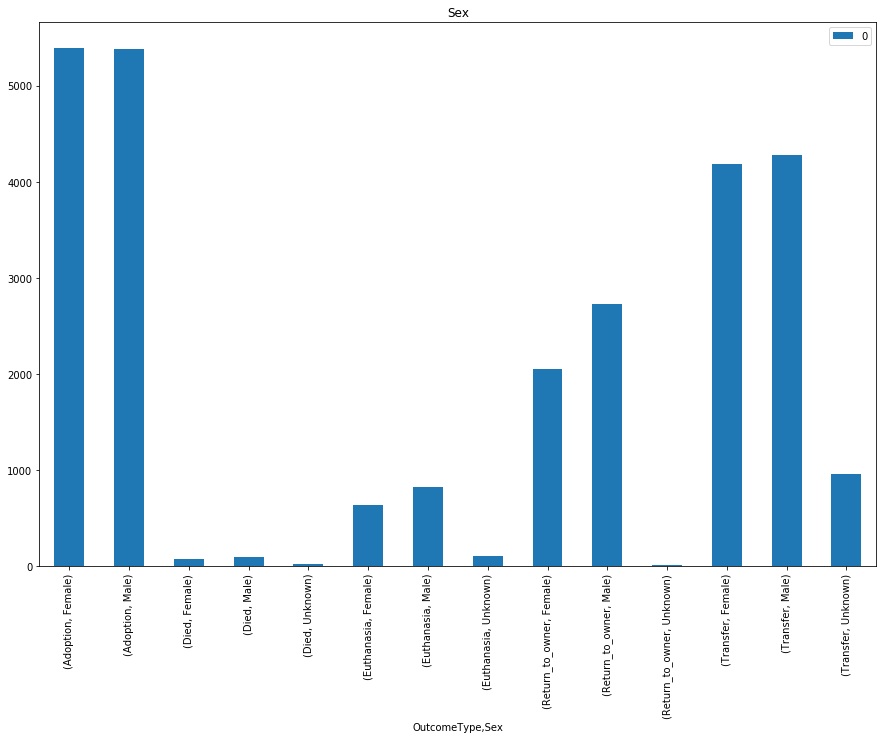

In [26]:
Sex_graph = Sex.plot(kind='bar', title ="Sex", figsize=(15, 10), legend=True, fontsize=10)
plt.show()

In [27]:
copy = SexuponOutcome_('SexuponOutcome')

In [28]:
copy.head(5)

,Age,Name,AnimalType,Breed,Color,Sterilized,Sex
0,365,1,Dog,Shetland Sheepdog Mix,Brown/White,Sterilized,Male
1,365,1,Cat,Domestic Shorthair Mix,Cream Tabby,Sterilized,Female
2,730,1,Dog,Pit Bull Mix,Blue/White,Sterilized,Male
3,21,0,Cat,Domestic Shorthair Mix,Blue Cream,Intact,Male
4,730,0,Dog,Lhasa Apso/Miniature Poodle,Tan,Sterilized,Male


In [29]:
copy.tail(5)

,Age,Name,AnimalType,Breed,Color,Sterilized,Sex
38180,60,0,Cat,Domestic Shorthair Mix,Black,Sterilized,Male
38181,14,0,Cat,Domestic Shorthair Mix,Blue,Intact,Female
38182,365,0,Cat,Domestic Shorthair Mix,Calico,Intact,Female
38183,2190,1,Dog,German Shepherd Mix,Black/Tan,Sterilized,Male
38184,1460,1,Dog,Labrador Retriever,Cream,Intact,Male


#### 5) Breed & Color

In [30]:
def breed_mapping(x):
    x = str(x)
    if '/' in x:
        return 'hybrid'
    return x

In [31]:
# mix 앞에 거 , 순종, / 앞에거로만 변수로 취급.
def Breed_():
    copy['Breed_Hybrid'] = copy['Breed'].apply(lambda x: 1 if '/' in x else 0)
    del copy['Breed']
    return copy
def Color_():
    copy['Color_Mixed'] = copy['Color'].apply(lambda x: 1 if '/' in x else 0)
    del copy['Color']
    return copy

def Breed_group():
    group_copy['Breed'] = group_copy['Breed'].apply(lambda x: 1 if '/' in x else 0)
    return group_copy
def Color_group():
    group_copy['Color_Mixed'] = group_copy['Color'].apply(lambda x: 1 if '/' in x else 0)
    return group_copy

In [32]:
copy = Breed_()
copy = Color_()

In [33]:
Breed = Breed_group()
Color = Color_group()

Dummy coding

In [34]:
dummy_columns = ['Name', 'AnimalType', 'Sterilized', 'Sex', 'Breed_Hybrid', 'Color_Mixed']
copy = pd.get_dummies(copy, columns=dummy_columns)

In [35]:
copy.head(5)

,Age,Name_0,Name_1,AnimalType_Cat,AnimalType_Dog,Sterilized_Intact,Sterilized_Sterilized,Sterilized_Unknown,Sex_Female,Sex_Male,Sex_Unknown,Breed_Hybrid_0,Breed_Hybrid_1,Color_Mixed_0,Color_Mixed_1
0,365,0,1,0,1,0,1,0,0,1,0,1,0,0,1
1,365,0,1,1,0,0,1,0,1,0,0,1,0,1,0
2,730,0,1,0,1,0,1,0,0,1,0,1,0,0,1
3,21,1,0,1,0,1,0,0,0,1,0,1,0,1,0
4,730,1,0,0,1,0,1,0,0,1,0,0,1,1,0


##### Breed의 경우
- Mix인 경우 순종과 패턴이 비슷한 것을 알 수 있었고, 예를 들면 A Mix이면 A 종에 가까운 믹스견이라는 것을 전문가를 통해 알게되어 Mix를 순종으로 보았다.
- 순종인 경우와 잡종인 경우에 따라 OutcomeType이 다른것을 볼 수 있다.
- 아쉬운점 : 어떤 종이 어떤 패턴을 보이는지 확인하기 어려웠다. 종 마다의 크기에 따라 나눠서 생각해 볼 수 있었는데, 이 아이디어를 늦게 알게 되어 해보지 못해 아쉽다.

In [36]:
shelter_Breed = group_copy.groupby(['OutcomeType', 'Breed'])
shelter_Breed.size()
shelter_Breed = pd.DataFrame(shelter_Breed.size())
shelter_Breed

0
OutcomeType     Breed      
Adoption        0      9226
                1      1543
Died            0       188
                1         9
Euthanasia      0      1428
                1       127
Return_to_owner 0      4145
                1       641
Transfer        0      8684
                1       738

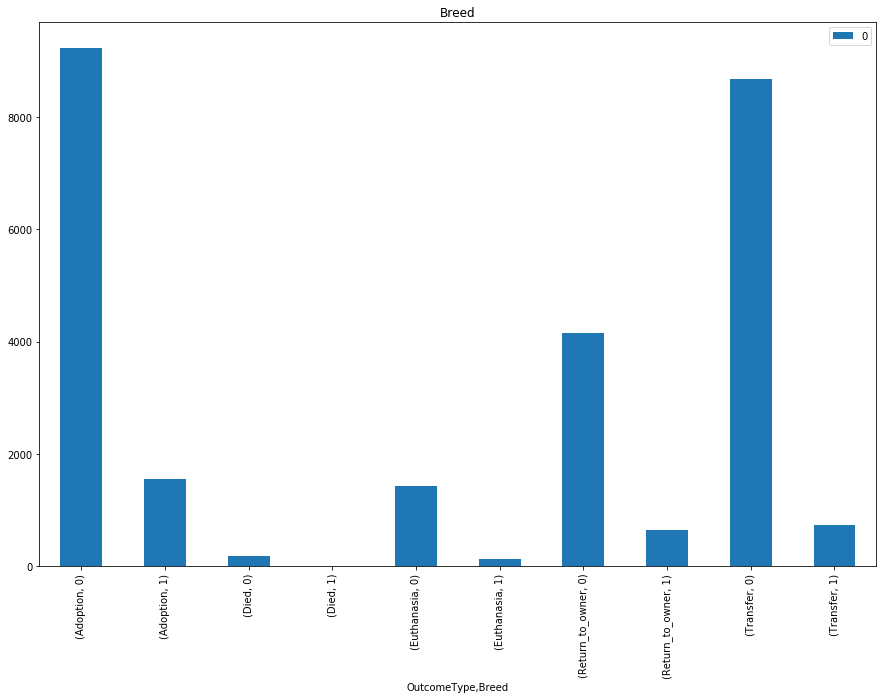

In [37]:
shelter_Breed_graph = shelter_Breed.plot(kind='bar', title ="Breed", figsize=(15, 10), legend=True, fontsize=10)
plt.show()

##### Color의 경우
- Breed와 마찬가지로 색별로 OutcomeType이 어떻게 다른지 확인하기가 어려웠다. 색 계열별로 알아보고자 시도했으나 이 역시 늦게 아이디어를 얻게 되어 시간을 맞추지 못했다.

In [38]:
shelter_Color = group_copy.groupby(['OutcomeType', 'Color_Mixed'])
shelter_Color = pd.DataFrame(shelter_Color.size())
shelter_Color

0
OutcomeType     Color_Mixed      
Adoption        0            4953
                1            5816
Died            0             106
                1              91
Euthanasia      0             722
                1             833
Return_to_owner 0            1897
                1            2889
Transfer        0            5127
                1            4295

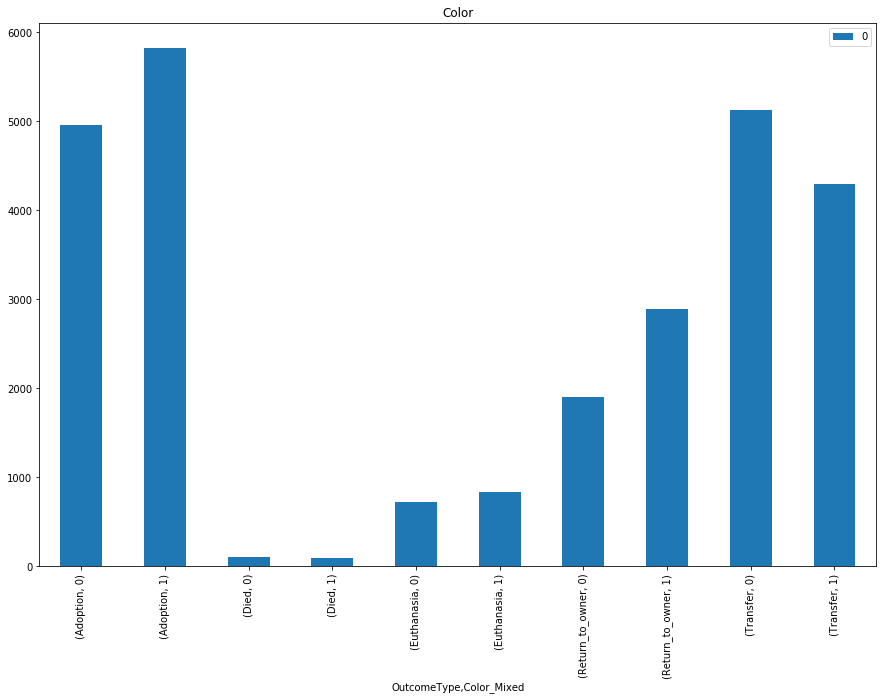

In [39]:
shelter_Color_graph = shelter_Color.plot(kind='bar', title ="Color", figsize=(15, 10), legend=True, fontsize=10)
plt.show()

### 3. Scaling

In [40]:
scaler = StandardScaler()
copy['Age'] = scaler.fit_transform(copy['Age'].values.reshape(-1, 1))

C:\python35\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [41]:
copy.tail(5)

,Age,Name_0,Name_1,AnimalType_Cat,AnimalType_Dog,Sterilized_Intact,Sterilized_Sterilized,Sterilized_Unknown,Sex_Female,Sex_Male,Sex_Unknown,Breed_Hybrid_0,Breed_Hybrid_1,Color_Mixed_0,Color_Mixed_1
38180,-0.675012,1,0,1,0,0,1,0,0,1,0,1,0,1,0
38181,-0.717620,1,0,1,0,1,0,0,1,0,0,1,0,1,0
38182,-0.392498,1,0,1,0,1,0,0,1,0,0,1,0,1,0
38183,1.297956,0,1,0,1,0,1,0,0,1,0,1,0,0,1
38184,0.621775,0,1,0,1,1,0,0,0,1,0,1,0,1,0


### 4. Split Dataset

shape of train / test / copy dataest

In [42]:
print (train.shape, test.shape, copy.shape)

(26729, 10) (11456, 8) (38185, 15)


copy => train + test

In [43]:
train_x = copy.loc[:26728]
Lec = LabelEncoder()
train_y = Lec.fit_transform(train['OutcomeType'].values)
#train_y = pd.DataFrame(train_y)
test_x = copy.loc[26729:]

In [44]:
print (train_x.shape, train_y.shape)

(26729, 15) (26729,)


train => train + test(validation)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, random_state=1)

In [46]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20046, 15) (6683, 15) (20046,) (6683,)


# III. Model_Selection & Evaluation

Grid Search

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report

In [48]:
def inv_outcometype_mapping(x):
    if x == 0:
        return 'Adoption'
    elif x == 1:
        return 'Died'
    elif x == 2:
        return 'Euthanasia'
    elif x == 3:
        return 'Return_to_owner'
    elif x == 4:
        return 'Transfer'

    
def Best_Parameters(model, hyperparameter_space):
    model = GridSearchCV(estimator = model, 
                         param_grid = hyperparameter_space, 
                         cv=10)
    model.fit(X_train, y_train)
    
    return model.best_params_
    
    
def RandomForest_Model():
    model = RandomForestClassifier()
    hyperparameter_space = {'n_estimators' : [350, 375, 400],
                            'max_features' : ['auto', 'log2']
                           }

    best_params = Best_Parameters(model, hyperparameter_space)
    rf = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                                max_features=best_params['max_features']).fit(X_train, y_train)
    print (best_params)
    return rf


def SVM_Model():
    model = SVC()
    hyperparameter_space = {'gamma': ['auto'], 
                            'C': [10, 15]}

    best_params = Best_Parameters(model, hyperparameter_space)
    svc = SVC(gamma = best_params['gamma'], 
              C = best_params['C']).fit(X_train, y_train)
    print (best_params)
    return svc


def KNN_Model():
    model = KNeighborsClassifier()
    hyperparameter_space = {'n_neighbors': [16, 18, 20], 
                            'leaf_size': [25]}

    best_params = Best_Parameters(model, hyperparameter_space)
    knn = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], 
                               leaf_size = best_params['leaf_size']).fit(X_train, y_train)
    print (best_params)
    return knn


def Prediction(model, data):
    prediction = {}
    try:
        predicted = model.predict(data.values)
        prediction['predicted'] = predicted

        predicted_proba = model.predict_proba(data.values)
        prediction['predicted_proba'] = predicted_proba
    except:
        pass
    
    return prediction
    

def Result(model):
    result = {}
    OutcomeType = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
    
    result['model'] = model
    result['prediction'] = Prediction(model, X_test)
    result['report'] = classification_report(y_test, 
                                             Prediction(model, X_test)['predicted'],
                                             target_names=OutcomeType)
    result['score'] = model.score(X_test, y_test)
    
    return result


def Show_Feature_Importances(f_importances):
    f_importances = rf.feature_importances_
    indices = f_importances.argsort()[::-1] # rank 높은 index부터 정렬
    f_importances_sorted = []
    for idx in indices:
        f_importances_sorted.append(f_importances[idx])

    pd.Series(f_importances_sorted, index=copy.columns).plot(kind='bar', color='r')

### 1. KNN

Model selection

In [49]:
%%time
knn = KNN_Model()

{'leaf_size': 25, 'n_neighbors': 18}
Wall time: 44.1 s


Model evalutaion

In [50]:
knn_result = Result(knn)

C:\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [51]:
pprint (knn_result)

{'model': KNeighborsClassifier(algorithm='auto', leaf_size=25, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=18, p=2,
           weights='uniform'),
 'prediction': {'predicted': array([0, 3, 0, ..., 0, 3, 0], dtype=int64),
                'predicted_proba': array([[ 0.33333333,  0.        ,  0.22222222,  0.22222222,  0.22222222],
       [ 0.27777778,  0.        ,  0.11111111,  0.61111111,  0.        ],
       [ 0.94444444,  0.        ,  0.        ,  0.05555556,  0.        ],
       ..., 
       [ 0.77777778,  0.        ,  0.        ,  0.11111111,  0.11111111],
       [ 0.22222222,  0.        ,  0.        ,  0.66666667,  0.11111111],
       [ 0.94444444,  0.        ,  0.        ,  0.05555556,  0.        ]])},
 'report': '                 precision    recall  f1-score   support\n'
           '\n'
           '       Adoption       0.64      0.79      0.71      2711\n'
           '           Died       0.00      0.00      0.00        50\n'
           '     Euthan

### 2. SVM

Model selection

In [53]:
%%time
svc = SVM_Model()

{'C': 10, 'gamma': 'auto'}
Wall time: 11min 21s


Model evaluation

In [54]:
svc_result = Result(svc)

C:\python35\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
pprint (svc_result)

{'model': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
 'prediction': {'predicted': array([3, 0, 0, ..., 0, 3, 0], dtype=int64)},
 'report': '                 precision    recall  f1-score   support\n'
           '\n'
           '       Adoption       0.62      0.88      0.73      2711\n'
           '           Died       0.00      0.00      0.00        50\n'
           '     Euthanasia       0.61      0.10      0.17       389\n'
           'Return_to_owner       0.50      0.37      0.43      1169\n'
           '       Transfer       0.76      0.61      0.68      2364\n'
           '\n'
           '    avg / total       0.64      0.64      0.62      6683\n',
 'score': 0.6438725123447554}


### 3. Random Forest

Model selection

In [56]:
%%time
rf = RandomForest_Model()

{'max_features': 'log2', 'n_estimators': 325}
Wall time: 8min 44s


Model evaluation

In [57]:
rf_result = Result(rf)

In [58]:
pprint (rf_result)

{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=325, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 'prediction': {'predicted': array([2, 3, 0, ..., 0, 3, 0], dtype=int64),
                'predicted_proba': array([[ 0.22059949,  0.        ,  0.40057349,  0.1827622 ,  0.19606482],
       [ 0.27751527,  0.00413537,  0.06675447,  0.50630758,  0.14528731],
       [ 0.9568115 ,  0.        ,  0.        ,  0.0431885 ,  0.        ],
       ..., 
       [ 0.78177286,  0.        ,  0.        ,  0.11535226,  0.10287488],
       [ 0.31621695,  0.        ,  0.        ,  0.51744721,  0.16633584],
       [ 0.91388573,  0.        ,  0.        ,  0.03831719,  0.04779707]])},
 'report': '                 precisi

Feature importances

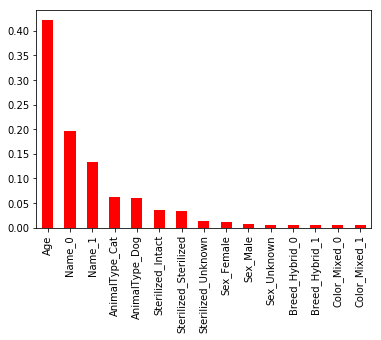

In [59]:
Show_Feature_Importances(rf.feature_importances_)

### 4. Xgboost

In [103]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train_x.values, 
                                                                     train_y[0].values)

In [111]:
xgbr = xgb.XGBClassifier(
    n_estimators = 400, ## 나무 갯수
    max_depth = 5,
).fit(X_train, y_train)

In [33]:
print('XGBClassfier score')
print(xgbr.score(X_test, y_test))

XGBClassfier score
0.647613347299


In [104]:
cross_val_score(xgbr, X_train, y_train, cv=5)

array([ 0.64273249,  0.63965087,  0.65402844,  0.6460464 ,  0.64237584])

F1 Score

In [112]:
xg_train_prediction = Prediction(xgbr, train_x)

In [114]:
y_predict = Test_Predicted_df(xg_train_prediction)
y_predict = Lec.fit_transform(y_predict['OutcomeType'].values)
y_predict = pd.DataFrame(y_predict)
y_predict.head(10)

y_answer = train_y

In [115]:
from sklearn.metrics import f1_score

f1_score(y_predict, y_answer, average = 'weighted')

0.66884958718007292

Feature Importance

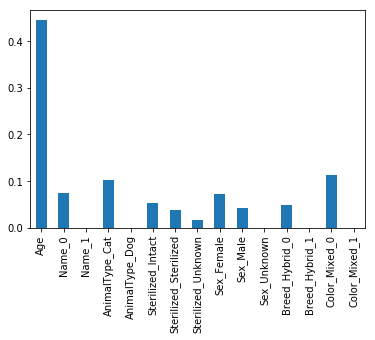

In [108]:
pd.Series(xgbr.feature_importances_, index=copy.columns).plot(kind='bar')

# IV. Prediction

In [100]:
def Test_Predicted_df(prediction):
    predicted = prediction['predicted']
    #predicted = predicted.astype('int64')
    predicted_df = pd.DataFrame(predicted, 
                                columns = ['OutcomeType'])
    predicted_df['OutcomeType'] = predicted_df['OutcomeType'].apply(int).apply(inv_outcometype_mapping)
    return predicted_df

def Test_Predicted_proba_df(prediction):
    predicted_proba = prediction['predicted_proba']
    predicted_proba_df = pd.DataFrame(predicted_proba, 
                                      columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])
    return predicted_proba_df

### 1. XGBoost

In [ ]:
Test_Predicted_df(xg_train_prediction).head(5)

In [ ]:
prediction = pd.DataFrame(xgbr.predict_proba(test_x.values))
prediction.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
prediction.head(5)